In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = sm.datasets.co2.load_pandas().data


In [3]:
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


 A good step in the beginning is to Visualize the data to get More familiar with it

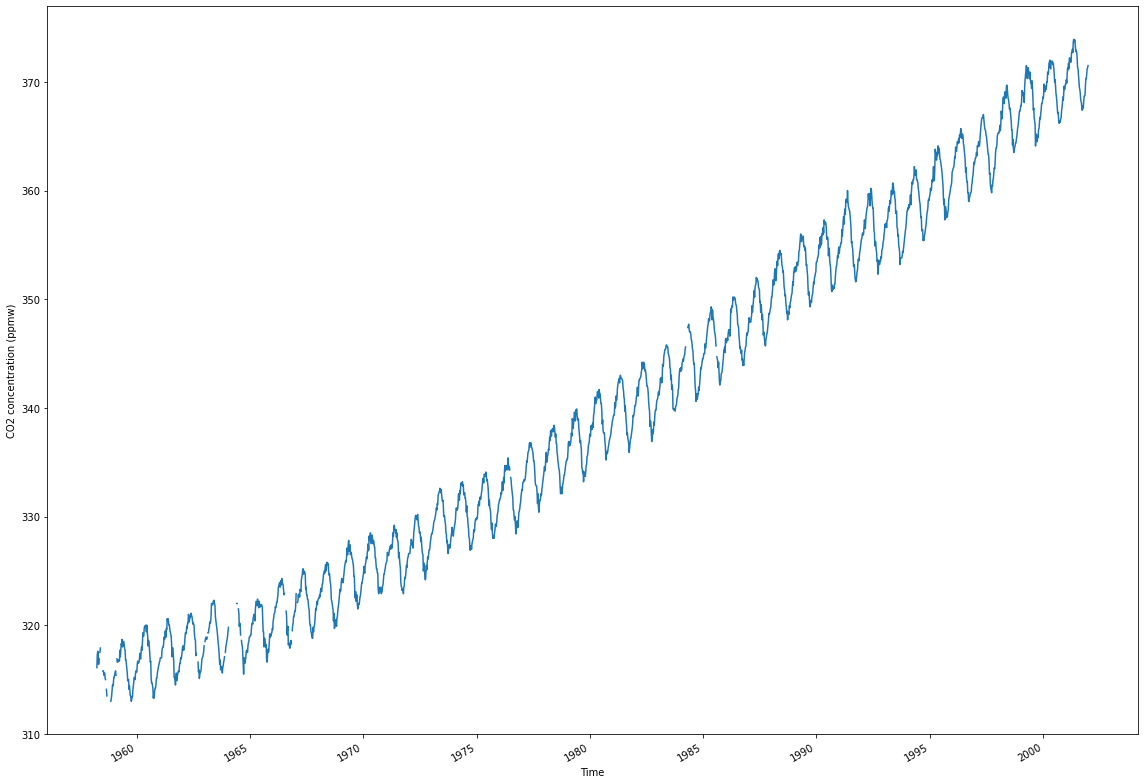

In [4]:
fig , ax = plt.subplots(figsize=(16,11))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

###### From the figure above we notice that our data have some missing values in the beginning , we also notice a clear positive trend as the concentration increases over time , and a yearly seasonal pattern and the is due to the change of seasons as Co2 concentration is higher during winter than during summer . 

* we are going to treat missing data using interpolation 
* We will simply take a linear interpolation between two known points to fill the missing values.

In [5]:
data = data.interpolate()
data.head(20)


,co2
1958-03-29,316.10
1958-04-05,317.30
1958-04-12,317.60
1958-04-19,317.50
1958-04-26,316.40
1958-05-03,316.90
1958-05-10,317.20
1958-05-17,317.50
1958-05-24,317.90
1958-05-31,317.55


Since the mising values are now gone , we can now use scikit-learn for Modelling 

There are 3 different ways in which we can frame a time series forecasting problem as a supervised learning problem:

1. Predict the next time step using the previous observation
2. Predict the next time step using a sequence of past observations
3. predict a sequence of future time steps using a sequence of past observations

**Predict the next time step using the previous observation**

This is the most basic setup. The model outputs a prediction for the next time step, given only the previous observation As {Yt > model > Yt+1} , This is a simple use case with little practical applications, since a model is likely not going to learn anything from the previous observation only.

 all the values in the dataset are in single column, but we need to format the dataset such that the current observation is a feature to predict the next observation (the target).

So, we add a second column that simply shifts the co2 column such that the value in 1958–03–29 is now a predictor for the value in 1958–04–05.

In [6]:
df = data.copy()
df['y'] = df['co2'].shift(-1)

In [7]:
df.head()

,co2,y
1958-03-29,316.1,317.3
1958-04-05,317.3,317.6
1958-04-12,317.6,317.5
1958-04-19,317.5,316.4
1958-04-26,316.4,316.9


Our dataset is now formatted such that each current observation is a predictor for the next observation but we now  have a missing value of the end of our dataset. This is normal for the last known observation. We will remove this row in a future step.

#### **We now need to split the dataset into training and testing sets to be able to evaluate  the accuracy of the model in the future ,  using the last two years of data for the training set ,Since we have weekly data, and there are 52 weeks in a year, it means that the last 104 samples are kept for the test set.**

In [8]:
train = df[:-104]
test = df[-104:]
# Now we romove the last row
test = test.drop(test.tail(1).index)
test.shape

(103, 2)

**Baseline model**

Of course, we need a baseline model to determine if using machine learning models is better. Here, we naively predict that the next observation will have the same value as the current observation.

In other words, we simply set the co2 column as our baseline predictions.

In [9]:
test = test.copy()
test['base_line'] = test['co2']

In [10]:
test.head()

,co2,y,base_line
2000-01-08,368.5,369.0,368.5
2000-01-15,369.0,369.8,369.0
2000-01-22,369.8,369.2,369.8
2000-01-29,369.2,369.1,369.2
2000-02-05,369.1,369.6,369.1


With this step done we now can go for Modelling , I'm gonna apply a decision tree regressor - using random state to ensure reproducibility - .


In [11]:
from sklearn.tree import DecisionTreeRegressor
x_train = train['co2'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['co2'].values.reshape(-1,1)
#initialize the model 
dt_reg =  DecisionTreeRegressor(random_state=42)
# fit the model
dt_reg.fit(X=x_train,y= y_train)
#making predictions
dt_pred = dt_reg.predict(X_test)
#assigning predictions to a new column 
test['dt_pred'] = dt_pred

In [12]:
test

,co2,y,base_line,dt_pred
2000-01-08,368.5,369.0,368.5,368.650000
2000-01-15,369.0,369.8,369.0,368.500000
2000-01-22,369.8,369.2,369.8,369.400000
2000-01-29,369.2,369.1,369.2,369.100000
2000-02-05,369.1,369.6,369.1,368.800000
...,...,...,...,...
2001-11-24,370.3,370.3,370.3,370.533333
2001-12-01,370.3,370.8,370.3,370.533333
2001-12-08,370.8,371.2,370.8,370.800000
2001-12-15,371.2,371.3,371.2,371.000000


For more diversity we could use another model such as Gradient boosting

 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_train,y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred
test

,co2,y,base_line,dt_pred,gbr_pred
2000-01-08,368.5,369.0,368.5,368.650000,368.556464
2000-01-15,369.0,369.8,369.0,368.500000,368.774435
2000-01-22,369.8,369.2,369.8,369.400000,369.512468
2000-01-29,369.2,369.1,369.2,369.100000,369.041813
2000-02-05,369.1,369.6,369.1,368.800000,368.774435
...,...,...,...,...,...
2001-11-24,370.3,370.3,370.3,370.533333,370.535661
2001-12-01,370.3,370.8,370.3,370.533333,370.535661
2001-12-08,370.8,371.2,370.8,370.800000,370.710834
2001-12-15,371.2,371.3,371.2,371.000000,371.049344


Having predications from two different model so we have to evaluate the performance of each.

In [14]:
# im] gonna use (MAPE) -mean absolute error
def mape(y_true,y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

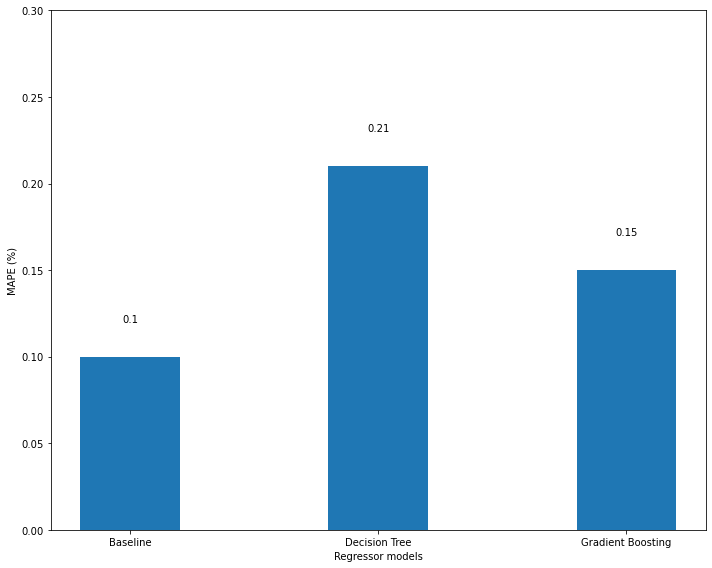

In [15]:
test.rename(columns={"base_line":"baseline_pred"},inplace=True)
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['co2'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(10, 8))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

The figure showa that the baseline has the best performance since it has the lowest MAPE ,"This makes sense as the CO2 concentration does not seem to change drastically from one week to another."

In this case, using machine learning models did not give us any added value. Again, this might be because the model is only learning from one observation to make a prediction. It might be better to give it a sequence as input, in order to predict the next time step.

This brings us to the next scenario

Predict the next time step using a sequence of past observations
As we have seen in the previous example, using a single observation to predict the next time step did not work very well. Now, let’s try using a sequence as input to the model and predict the next time step.

Again, we must format our dataset such that we have a sequence of past observations acting as predictors to the following time step we can easily write a function that adds shifted columns to get the desired input length.

In [16]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['co2'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [17]:
new_df = window_input(5, data)
new_df

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55
...,...,...,...,...,...,...
2001-10-27,368.7,368.7,368.8,369.7,370.3,370.30
2001-11-03,368.7,368.8,369.7,370.3,370.3,370.80
2001-11-10,368.8,369.7,370.3,370.3,370.8,371.20
2001-11-17,369.7,370.3,370.3,370.8,371.2,371.30


we can see that our dataset is arranged in such a way that we have five observations to predict the next time step, stored in the y column.

This essentially takes care of the hardest part! Now, it is simply matter of applying different models and seeing which performs best.

Before heading to that step, let’s first split our data into a training and a test set.

In [18]:
from sklearn.model_selection import train_test_split
X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)



define a baseline model for this situation

In [19]:
#Here, we will simply predict the mean of the input sequence
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [20]:
#Applying decision tree regressor
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

In [21]:
#Applying Gradient  boosting
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

We can now evaluate the performance of each model. Again, we use the MAPE and plot the results in a bar plot.

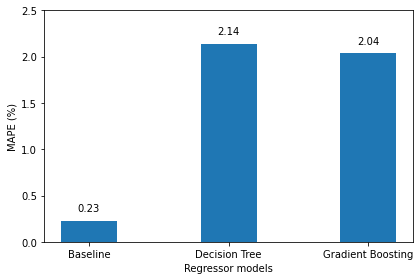

In [22]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

 we see that the machine learning models do not outperform the baseline.

hyperparameter tuning can likely increase the performance of the ML models, but the input window is too short. An input of five weeks is not enough for the model to pick up the trend and seasonal components, so we might need a longer window of time.

We will try exactly that in the next scenario

#### **Predict a sequence of future time steps using a sequence of past observations**
The final scenario is using a sequence of observations to predict a sequence of future time steps.


Here, our model is required to output a sequence of predictions. This can be seen as a multi-output regression problem.

So, the first step is to format our dataset appropriately. We develop another function that uses the shift method to format the dataset as a multi-output regression problem.

In [23]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [24]:
 """Here, we will use a sequence of 26 observations to predict the next 26 time steps.
In other words, we input half of a year to predict the next half. Note that the input
and output sequences do not need to have the same length. This is an arbitrary decision 
on my end."""
seq_df = window_input_output(26, 26, data)




In [27]:
seq_df


,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-09,369.6,369.3,369.5,369.8,369.8,370.20,369.90,370.80,371.30,371.10,...,367.40,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.3
2000-12-16,369.3,369.5,369.8,369.8,370.2,369.90,370.80,371.30,371.10,371.70,...,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.8
2000-12-23,369.5,369.8,369.8,370.2,369.9,370.80,371.30,371.10,371.70,371.20,...,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.2
2000-12-30,369.8,369.8,370.2,369.9,370.8,371.30,371.10,371.70,371.20,372.20,...,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.20,371.3


we now have a dataset where 26 observations are used as predictors for the next 26 time steps.
Before moving on to modeling, again, we will split the data into a training and a test set. Here, we reserve the last two rows for the test set, as it gives us 52 test samples.

In [28]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

Baseline model
we will simply repeat the input sequence. 
we take the input sequence and output the same sequence as our baseline predictions.
Again, let’s try applying a decision tree.

In [29]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

**Gradient boosting**
gradient boosting takes a bit of extra work. It cannot handle a multi-output target. Trying to fit a gradient boosting model immediately will result in an error.
we must wrap the model such that its prediction is used as an input to feed the next prediction. This is achieved using the RegressorChain wrapper from scikit-learn.

In [30]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

This allowed to train the model and make predictions without encountering any errors. behind the scenes, the model predicts the next time step, and uses that prediction to make the next prediction. The drawback of that method is that if the first prediction is bad, then the rest of the sequence is likely going to be bad.

evaluating each model .

Again, we use the MAPE to evaluate our forecasting methods.



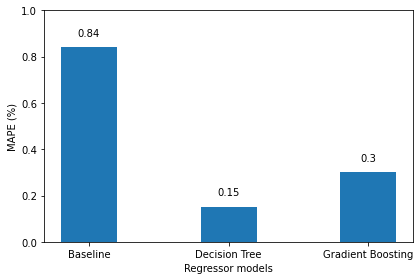

In [31]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

From the figure above, we can see that we finally managed to train ML models that outperform the baseline! Here, the decision tree model is the champion model, as it achieves the lowest MAPE.
visualizing the predictions over the last year.



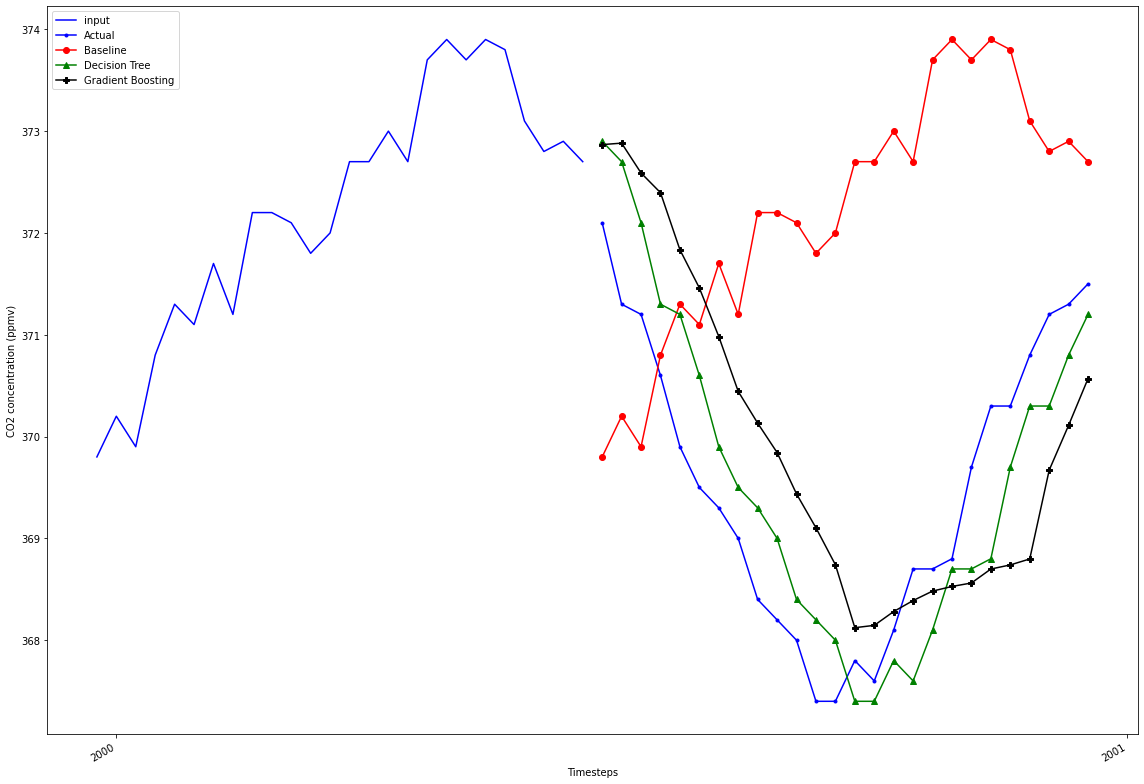

In [32]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')
plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()